# Introduction

Is it possible to infer a movie category/genre, or a set of categories, based on its synopsis/overview? In this notebook, I will execute an extensive data analysis on over 4.5k movies exploring its categories and overview. Let's try to predict a movie's category based on text - its overview!

Dataset: [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv): Metadata on ~5,000 movies from TMDb.

# Loading the data

- Importing main libraries
- Listings files of the dataset
- Loading data into a `pandas.DataFrame`

Importing the main libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # visualization

In [2]:
# from: https://www.kaggle.com/sohier/getting-imdb-kernels-working-with-tmdb-data/
import json

def loadMovies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def loadCredits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

Listing the files.

In [3]:
import os

# Listing files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


Loading the movies' data.

In [4]:
# Loading movies
dfMovies = loadMovies("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")

# Filtering columns
columnsOfInterest = ['id', 'title', 'genres', 'overview']
dfMovies = dfMovies[columnsOfInterest]
# Removing null(overview)
dfMovies = dfMovies[dfMovies['overview'].notnull()].reset_index(drop=True)

# Print
display(dfMovies.head(3))

,id,title,genres,overview
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",A cryptic message from Bond’s past sends him o...


---
# Movies' categories

Which movie categories do we have in this dataset? How many movies per category do we have?

In [5]:
# Counting number of categories
categoriesCount = {}

for index, row in dfMovies.iterrows():
    for category in row['genres']:
        catName = category['name']
        categoriesCount[catName] = categoriesCount[catName]+1 if (catName in categoriesCount) else 1

In [6]:
print('number of categories:', len(categoriesCount.keys()))

number of categories: 20


As we can see, we have a few categories presented in a high number of movies (_e.g.,_ Drama) and others not so much (_e.g.,_ TV Movie). 
At this point, we have to specify the importance of these low representative categories for our project.
For studying proposes, I will maintain all of the categories. However, note that this action can injure our future prediction.

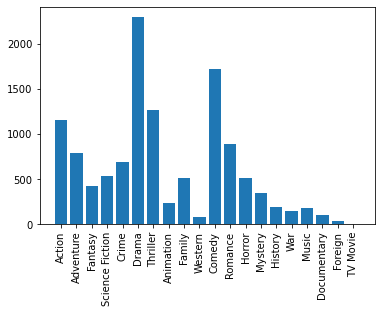

In [7]:
# Plotting
keys = categoriesCount.keys()
values = categoriesCount.values()

plt.bar(keys, values)
plt.xticks(rotation='vertical')
plt.show()

---
# NLP (Natural Language Processing)

Extract attributes from the movies' overview to create vectors of characteristics describing the movies and their categories.

## Data Pre-processing

It will perform the following steps:

- **Tokenization** - split the sentences into words/tokens. Lowercase the words and remove punctuation.
    - Words that have fewer than 3 characters are removed.
    - All [stopwords](https://en.wikipedia.org/wiki/Stop_word) are removed.
- **Lemmatization** — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- **Stemming** — words are reduced to their root form.

In [8]:
import gensim # topic modeling toolkit
import nltk # natural language toolkit

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Preprocess coding _(hide)_.

In [9]:
# Lemmatization process
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


# Stemming process
def stemming(text):
    return stemmer.stem(text)


# Tokenization process
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            LemmatizedToken = lemmatize(token)
            result.append(stemming(LemmatizedToken))
    return result

Testing preprocess -    
Selecting a random movie.

In [10]:
movie = dfMovies.loc[255]
display(movie)

id                                                      13700
title                                       Home on the Range
genres      [{'id': 16, 'name': 'Animation'}, {'id': 10751...
overview    When a greedy outlaw schemes to take possessio...
Name: 255, dtype: object

In [11]:
overview = movie['overview']
print(overview)

When a greedy outlaw schemes to take possession of the "Patch Of Heaven" dairy farm, three determined cows, a karate-kicking stallion and a colorful corral of critters join forces to save their home. The stakes are sky-high as this unlikely animal alliance risk their hides and match wits with a mysterious band of bad guys.


In [12]:
print(preprocess(overview))

['greedi', 'outlaw', 'scheme', 'possess', 'patch', 'heaven', 'dairi', 'farm', 'determin', 'cow', 'karat', 'kick', 'stallion', 'color', 'corral', 'critter', 'join', 'forc', 'save', 'home', 'stake', 'high', 'unlik', 'anim', 'allianc', 'risk', 'hide', 'match', 'wit', 'mysteri', 'band', 'guy']


Preprocess all movies.

In [13]:
processedMovies = dfMovies['overview'].map(preprocess)
display(processedMovies)

0       [centuri, parapleg, marin, dispatch, moon, pan...
1       [captain, barbossa, long, believ, dead, come, ...
2       [cryptic, messag, bond, past, send, trail, unc...
3       [follow, death, district, attorney, harvey, de...
4       [john, carter, weari, militari, captain, inexp...
                              ...                        
4795    [mariachi, want, play, guitar, carri, famili, ...
4796    [newlyw, coupl, honeymoon, upend, arriv, respe...
4797    [sign, seal, deliv, introduc, dedic, quartet, ...
4798    [ambiti, york, attorney, send, shanghai, assig...
4799    [second, grade, brian, herzling, crush, draw, ...
Name: overview, Length: 4800, dtype: object

## Bag of Words (BOW)

The [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model is a representation used in natural language processing to transform the document into number vectors. In this model, a document is represented as the bag of its words, disregarding grammar and even word order but keeping multiplicity/quantity.

In [14]:
dictionary = gensim.corpora.Dictionary(processedMovies)

Filter out tokens that appear in

- Less than 10 movies (absolute number); or
- More than 50% movies (fraction of total corpus size).
- After that, keep only the first 100,000 most frequent tokens.

In [15]:
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

Gensim doc2bow

- Creating the movies' attributes/characteristics.
    - Using the dictionary to create the BOW.

In [16]:
bowCorpus = [dictionary.doc2bow(doc) for doc in processedMovies]

Preview a vector of characteristics.

In [17]:
display(bowCorpus[255])

[(26, 1),
 (57, 1),
 (113, 1),
 (129, 1),
 (132, 1),
 (199, 1),
 (226, 1),
 (235, 1),
 (241, 1),
 (288, 1),
 (319, 1),
 (451, 1),
 (472, 1),
 (510, 1),
 (537, 1),
 (567, 1),
 (776, 1),
 (1176, 1),
 (1300, 1),
 (1344, 1),
 (1439, 1),
 (1440, 1),
 (1441, 1),
 (1442, 1)]

## TF-IDF

[Term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (TF-IDF) is another way to represent the characteristics from movies, similar to bag-of-words.
TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [18]:
from gensim import corpora, models

tfidf = models.TfidfModel(bowCorpus)
tfidfCorpus = tfidf[bowCorpus]

Preview a vector of characteristics.

In [19]:
display(tfidfCorpus[255])

[(26, 0.12234971191857819),
 (57, 0.13852808277259349),
 (113, 0.19194197862609208),
 (129, 0.19257446151068044),
 (132, 0.2710640048244149),
 (199, 0.18034839556145862),
 (226, 0.24694038357766945),
 (235, 0.13586359907555673),
 (241, 0.2449020799154989),
 (288, 0.23121489820394345),
 (319, 0.131966296315022),
 (451, 0.195195419545093),
 (472, 0.18661096867588853),
 (510, 0.22834807211595207),
 (537, 0.1309584693253948),
 (567, 0.16512924280940205),
 (776, 0.21412614052899714),
 (1176, 0.22435822788680934),
 (1300, 0.20662303076587288),
 (1344, 0.1907025982567734),
 (1439, 0.2645022183668434),
 (1440, 0.24907352549935896),
 (1441, 0.22834807211595207),
 (1442, 0.21621078505628577)]

At this point, we have two ways to represent the movies' attributes - bag-of-words and tf-idf.   
**What can we do?** Classify categories, identify common topics into the movies, and so on.

# 1. Infer Categories

Note, a movie is composed of a set of categories. Thus, we have to identify $n$ categories to an unseen movie, because we do not know the number of categories that it has. 
In this way, we have to use a [soft classify](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3233196/) approach - that is a classifier that identify a set of classes to a record.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.matutils import corpus2dense

## Attributes

Creating a dense matrix, that is transform the words into a matrix of attributes.

In [21]:
tfidfDense = corpus2dense(tfidfCorpus, num_terms=100000, num_docs=len(tfidfCorpus))
tfidfDense = tfidfDense.T

In [22]:
print('movies, attributes:', tfidfDense.shape)

movies, attributes: (4800, 100000)


Getting characteristics of the categories:

- For each movie
    - For each category
        - Get its atributes and it category

In [23]:
denseMatrix, yCategory = [], []
for index, row in dfMovies.iterrows():
    for category in row['genres']:
        denseMatrix.append(tfidfDense[index])
        yCategory.append(category['name'])

Memory cleanning: reducing the decimals and deleting unused variables.

In [24]:
denseMatrix = [tup.astype(np.float16) for tup in denseMatrix]

In [25]:
del tfidfDense

## Trainning

Split the data into train and test datasets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(denseMatrix, yCategory, test_size=0.1, random_state=43)

print('train size:', len(y_train))
print('test size :', len(y_test))

train size: 10941
test size : 1216


Let's train our classifier. 

In [27]:
def getClassesProbabilities(model, record):
    probs = model.predict_proba([record]).T
    classes = model.classes_

    output = pd.DataFrame(data=[classes,probs]).T
    output.columns = ['category','probability']
    output['probability'] = output.apply(lambda x: x['probability'][0], axis=1)
    return output.sort_values(by='probability', ascending=False)

In [28]:
# Train model
clf = LogisticRegression(random_state=43, max_iter=150).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
from joblib import dump, load

# Save model
dump(clf, 'logisticRegression.model')

['logisticRegression.model']

In [30]:
# Load trained model
clf = load('logisticRegression.model') 

## Detecting categories

Predict a categorie, or a set of categories, to a movie.

In [31]:
clf.predict([X_test[1]])

array(['Drama'], dtype='<U15')

See the probability for other categories.

In [32]:
getClassesProbabilities(clf, X_test[1])

,category,probability
6,Drama,0.487831
14,Romance,0.119808
3,Comedy,0.104097
12,Music,0.067690
0,Action,0.033158
7,Family,0.031852
17,Thriller,0.021055
4,Crime,0.019568
1,Adventure,0.019270
8,Fantasy,0.018774


---
# 2. Topic Modeling

Topic modeling is a type of statistical modeling for discovering the abstract "topics" that occur in a set of documents. 
[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) model is an algorithm used to classify text in a document to a particular topic. 
A topic is represented by a set of most representative words (common words) that appear in a collection of documents.

References:

- [A Beginner’s Guide to Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)
- [Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

## Using bag-of-words (BOW)

In [33]:
ldaBow = gensim.models.LdaMulticore(bowCorpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

See the 5 most representative words for each abstract topic.

In [34]:
for idx, topic in ldaBow.print_topics(num_words=5):
    print('Topic: {} Words: {}'.format(idx, topic))

Topic: 0 Words: 0.011*"young" + 0.011*"life" + 0.008*"get" + 0.007*"stori" + 0.007*"star"
Topic: 1 Words: 0.014*"love" + 0.008*"life" + 0.008*"stori" + 0.007*"turn" + 0.007*"friend"
Topic: 2 Words: 0.014*"year" + 0.008*"film" + 0.008*"famili" + 0.007*"take" + 0.007*"world"
Topic: 3 Words: 0.010*"year" + 0.009*"life" + 0.009*"world" + 0.009*"live" + 0.008*"citi"
Topic: 4 Words: 0.013*"life" + 0.012*"friend" + 0.010*"world" + 0.009*"stori" + 0.007*"love"
Topic: 5 Words: 0.011*"young" + 0.011*"friend" + 0.010*"school" + 0.009*"world" + 0.007*"life"
Topic: 6 Words: 0.010*"year" + 0.009*"life" + 0.009*"famili" + 0.008*"stori" + 0.007*"young"
Topic: 7 Words: 0.013*"town" + 0.010*"young" + 0.008*"year" + 0.007*"world" + 0.007*"woman"
Topic: 8 Words: 0.015*"film" + 0.013*"live" + 0.009*"world" + 0.009*"love" + 0.008*"take"
Topic: 9 Words: 0.014*"life" + 0.010*"forc" + 0.009*"father" + 0.008*"friend" + 0.007*"find"


## Using TF-IDF

In [35]:
ldaTfidf = gensim.models.LdaMulticore(tfidfCorpus, num_topics=10, id2word=dictionary, passes=2, workers=4)

See the 5 most representative words for each abstract topic.

In [36]:
for idx, topic in ldaTfidf.print_topics(num_words=5):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"life" + 0.004*"turn" + 0.004*"famili" + 0.003*"young" + 0.003*"school"
Topic: 1 Word: 0.005*"stori" + 0.004*"life" + 0.004*"world" + 0.004*"young" + 0.004*"friend"
Topic: 2 Word: 0.004*"love" + 0.004*"friend" + 0.004*"young" + 0.004*"life" + 0.004*"year"
Topic: 3 Word: 0.004*"film" + 0.004*"meet" + 0.004*"year" + 0.004*"school" + 0.004*"stori"
Topic: 4 Word: 0.004*"year" + 0.004*"life" + 0.004*"famili" + 0.003*"friend" + 0.003*"father"
Topic: 5 Word: 0.004*"famili" + 0.004*"life" + 0.003*"friend" + 0.003*"world" + 0.003*"forc"
Topic: 6 Word: 0.004*"life" + 0.003*"help" + 0.003*"world" + 0.003*"stori" + 0.003*"love"
Topic: 7 Word: 0.004*"life" + 0.004*"stori" + 0.004*"world" + 0.003*"live" + 0.003*"help"
Topic: 8 Word: 0.004*"young" + 0.004*"world" + 0.004*"life" + 0.003*"love" + 0.003*"year"
Topic: 9 Word: 0.004*"lose" + 0.004*"famili" + 0.004*"young" + 0.004*"father" + 0.004*"live"


### Predicting Topic using LDA TF-IDF model

Check which topic a movie belongs to.

- Selecting a random movie - id 255.

In [37]:
for index, score in sorted(ldaTfidf[tfidfCorpus[255]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t Topic {}: {}".format(score, index, ldaTfidf.print_topic(index, 5)))


Score: 0.8442930579185486	 Topic 9: 0.004*"lose" + 0.004*"famili" + 0.004*"young" + 0.004*"father" + 0.004*"live"

Score: 0.01730569452047348	 Topic 4: 0.004*"year" + 0.004*"life" + 0.004*"famili" + 0.003*"friend" + 0.003*"father"

Score: 0.01730503886938095	 Topic 7: 0.004*"life" + 0.004*"stori" + 0.004*"world" + 0.003*"live" + 0.003*"help"

Score: 0.017302094027400017	 Topic 8: 0.004*"young" + 0.004*"world" + 0.004*"life" + 0.003*"love" + 0.003*"year"

Score: 0.01730138435959816	 Topic 1: 0.005*"stori" + 0.004*"life" + 0.004*"world" + 0.004*"young" + 0.004*"friend"

Score: 0.01730121485888958	 Topic 0: 0.005*"life" + 0.004*"turn" + 0.004*"famili" + 0.003*"young" + 0.003*"school"

Score: 0.017298445105552673	 Topic 6: 0.004*"life" + 0.003*"help" + 0.003*"world" + 0.003*"stori" + 0.003*"love"

Score: 0.017297767102718353	 Topic 3: 0.004*"film" + 0.004*"meet" + 0.004*"year" + 0.004*"school" + 0.004*"stori"

Score: 0.017297744750976562	 Topic 5: 0.004*"famili" + 0.004*"life" + 0.003*"fr

### Unseen movie using LDA BOW model

Check which topic a new movie belongs to.

- Topic identify for "Toy Story 4".

In [38]:
newMovie = "Woody attempts to make Forky, a toy, suffering from existential crisis, realise his importance in the life of Bonnie, their owner. However, things become difficult when Gabby Gabby enters their lives."
print(newMovie)

Woody attempts to make Forky, a toy, suffering from existential crisis, realise his importance in the life of Bonnie, their owner. However, things become difficult when Gabby Gabby enters their lives.


In [39]:
bowVector = dictionary.doc2bow(preprocess(newMovie))

for index, score in sorted(ldaBow[bowVector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic {}: {}".format(score, index, ldaBow.print_topic(index, 5)))

Score: 0.6099601984024048	 Topic 3: 0.010*"year" + 0.009*"life" + 0.009*"world" + 0.009*"live" + 0.008*"citi"
Score: 0.3233419954776764	 Topic 9: 0.014*"life" + 0.010*"forc" + 0.009*"father" + 0.008*"friend" + 0.007*"find"
